## 1. Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


## 2. Load and Prepare Data

In [2]:
df = pd.read_csv('data/train.csv')
val = pd.read_csv('data/val.csv')
test = pd.read_csv('data/test_without_label.csv')

def parse_vol_fixed(df):
    df['Vol.'] = df['Vol.'].astype(str)
    df['Vol.'] = (df['Vol.']
                  .str.replace('M', 'e6', regex=False)
                  .str.replace('K', 'e3', regex=False)
                  .astype(float))
    return df

def prepare(df, has_price=True):
    df['Date'] = pd.to_datetime(df['Date'])
    df.sort_values('Date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = parse_vol_fixed(df)
    features = df[['Open', 'High', 'Low', 'Vol.']].values
    target   = df['Price'].values.reshape(-1,1) if has_price else None
    return df, features, target

df, X_train, y_train = prepare(df, has_price=True)
val, X_val, y_val = prepare(val, has_price=True)
test, X_test, _ = prepare(test, has_price=False)

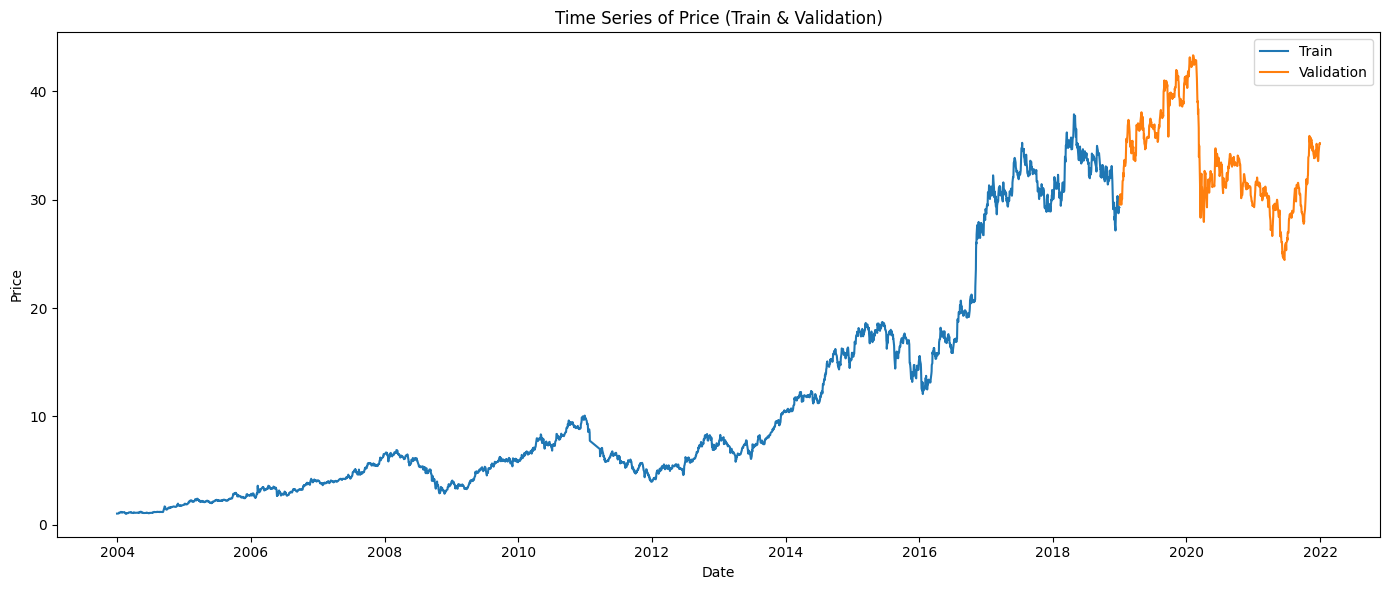

In [ ]:

plt.figure(figsize=(14, 6))
plt.plot(df['Date'], y_scaler.inverse_transform(y_train).ravel(), label='Train')
plt.plot(val['Date'], y_scaler.inverse_transform(y_val).ravel(), label='Validation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Time Series of Price (Train & Validation)')
plt.legend()
plt.tight_layout()
plt.show()

## 3. Scaling Features

In [3]:
x_scaler = MinMaxScaler().fit(X_train)
y_scaler = MinMaxScaler().fit(y_train)

X_train = x_scaler.transform(X_train)
X_val = x_scaler.transform(X_val)
X_test = x_scaler.transform(X_test)

y_train = y_scaler.transform(y_train)
y_val = y_scaler.transform(y_val)

## 4. Creating Time Series Windows

In [4]:
def create_windows(X, y=None, window=60):
    X_w, y_w = [], []
    for i in range(len(X) - window):
        X_w.append(X[i:i+window])
        if y is not None:
            y_w.append(y[i+window])
    return np.array(X_w), np.array(y_w) if y is not None else None

window_size = 60
X_tr_win, y_tr_win = create_windows(X_train, y_train, window_size)
X_val_win, y_val_win = create_windows(X_val, y_val, window_size)
X_te_win, _ = create_windows(X_test, None, window_size)

## 5. Build Model

In [5]:
model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(window_size, X_train.shape[1])),
    MaxPooling1D(2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

c:\Users\pc\OneDrive\Desktop\ML Assigment3\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 6. Train Model

In [6]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_tr_win, y_tr_win,
          validation_data=(X_val_win, y_val_win),
          epochs=50,
          batch_size=32,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.0166 - val_loss: 0.0019
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012 - val_loss: 0.0017
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.8285e-04 - val_loss: 0.0024
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.0678e-04 - val_loss: 0.0014
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.4123e-04 - val_loss: 0.0016
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.9468e-04 - val_loss: 0.0012
Epoch 9/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 8.7582e-04 - val_loss: 0.0019
Epoch 10/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 7.5405e-04 - val_loss: 0.0011
Epoch 11/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5456e-04 - val_loss: 0.0026
Epoch 12/50
1

## 7. Evaluate Model

In [7]:
y_pred_val = model.predict(X_val_win)
val_mae = np.mean(np.abs(y_pred_val - y_val_win))
print(f"Validation MAE (scaled): {val_mae:.4f}")
print(f"Validation MAE (original): {np.mean(np.abs(y_scaler.inverse_transform(y_pred_val) - y_scaler.inverse_transform(y_val_win))):.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Validation MAE (scaled): 0.0196
Validation MAE (original): 0.7226


## 8. Predict Test Data

In [8]:
y_pred_test = model.predict(X_te_win)
y_pred_test = y_scaler.inverse_transform(y_pred_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


## 9. Save Predictions

In [9]:
test_ids = test['ID'].iloc[window_size:].reset_index(drop=True)
test_dates = test['Date'].iloc[window_size:].reset_index(drop=True)

results = pd.DataFrame({
    'ID': test_ids,
    'Date': test_dates,
    'PredictedPrice': y_pred_test.ravel()
})

results.to_csv("predicted_prices.csv", index=False)
print("✅ Predictions saved to predicted_prices.csv")

✅ Predictions saved to predicted_prices.csv


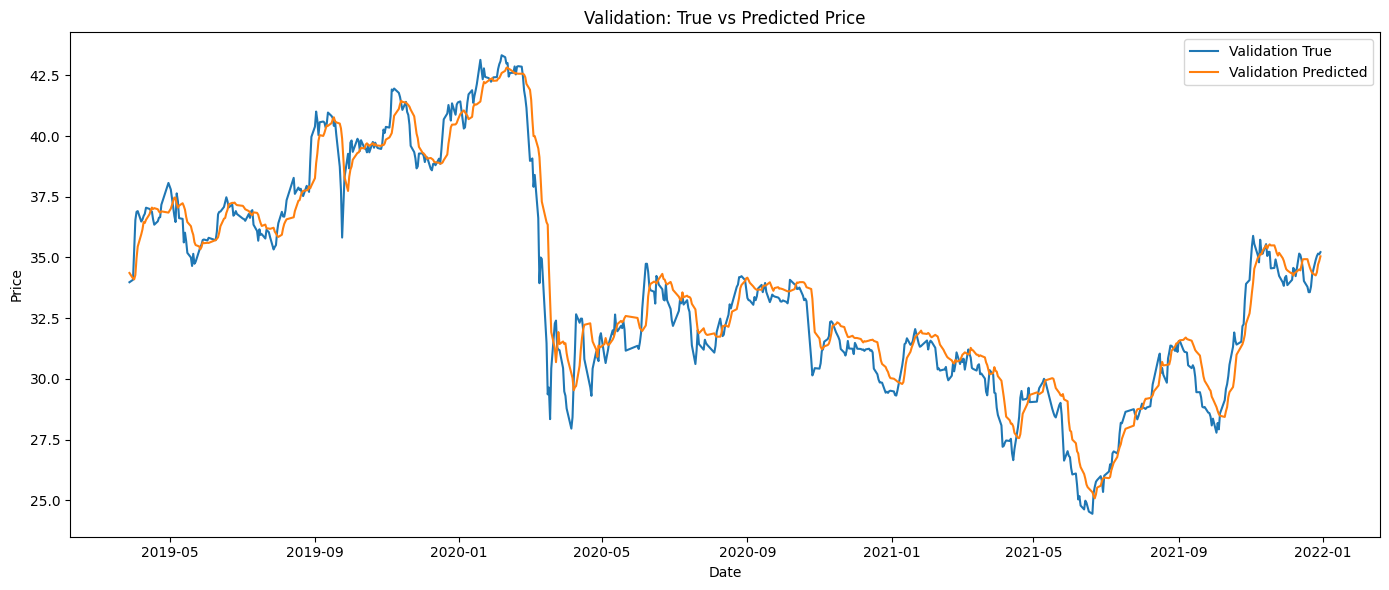

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(val['Date'].iloc[window_size:], y_scaler.inverse_transform(y_val_win).ravel(), label='Validation True')
plt.plot(val['Date'].iloc[window_size:], y_scaler.inverse_transform(y_pred_val).ravel(), label='Validation Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Validation: True vs Predicted Price')
plt.legend()
plt.tight_layout()
plt.show()

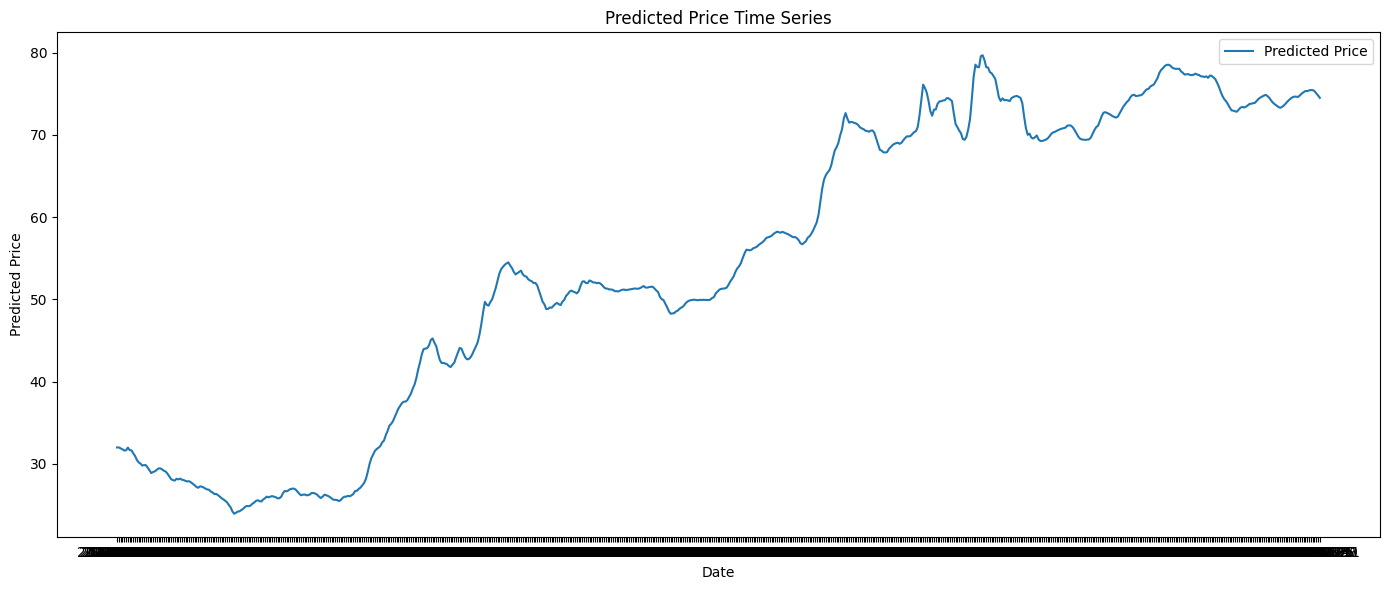

In [12]:
pred_df = pd.read_csv("predicted_prices.csv")

plt.figure(figsize=(14, 6))
plt.plot(pred_df['Date'], pred_df['PredictedPrice'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.title('Predicted Price Time Series')
plt.legend()
plt.tight_layout()
plt.show()